In [1]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd

/home/malik.ana/.conda/envs/emotional-safety/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We patch the hidden state (the activation vector) at the position of the last input token from the source run into the target  run. The goal is to see if this activation, which is hypothesized to represent the correct count from the source, can override the target context.

The patched probabilities represent the model's confidence in the source's answer (e.g., "3") after running on this target prompt. A high probability is the key signal: it provides strong causal evidence that the patched layer's activation was sufficient to make the model generate the correct count, meaning this is likely where that information is functionally represented.

In [2]:
def get_graph(filename):
    probs = torch.load(filename)
    df = pd.DataFrame(probs)
    baseline_prob = df['target_prob'].mean()
    patched_probs = np.array(df['patched_probabilities'].tolist())
    average_probs = patched_probs.mean(axis=0)
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    layers = np.arange(32)
    ax.plot(layers, average_probs, marker='o', linestyle='-', color='b', label='Patched Probability')
    ax.axhline(y=baseline_prob, color='r', linestyle='--', label=f'Baseline Probability ({baseline_prob:.4f})')

    ax.set_xlabel("Patched Layer Index", fontsize=12)
    ax.set_ylabel("Probablities")
    ax.set_xticks(layers)
    ax.tick_params(axis='x', rotation=45)


### Benchmarking for Patches across 10 examples

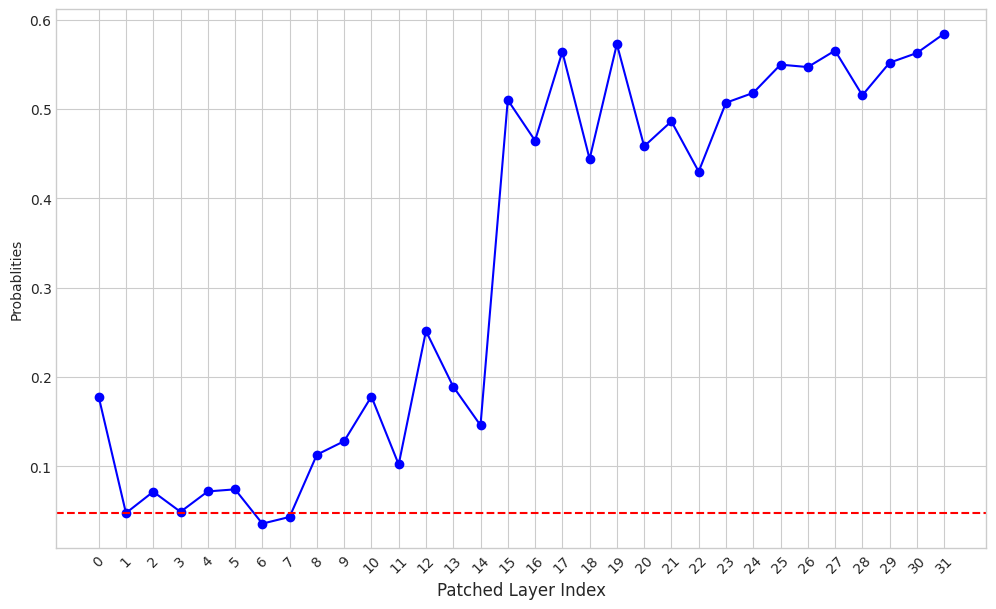

In [3]:
get_graph('output/causal_output_10.pt')

we see from layer 15 where this probability rises hence the count information is highly represented

### Model Patched Probs Across 1000 samples

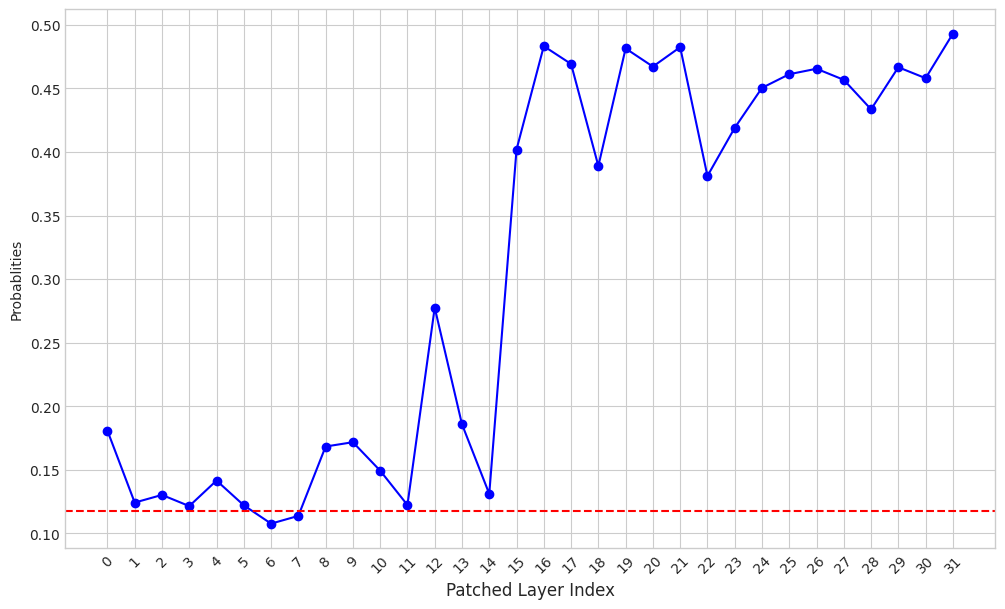

In [5]:
get_graph('output/causal_output_1000.pt')